# London Airbnb Visualizations

Creating 3 professional visualizations using PySpark and Matplotlib.

In [12]:
import os
import sys

os.environ['HADOOP_HOME'] = r'C:\hadoop'
os.environ['hadoop.home.dir'] = r'C:\hadoop'
os.environ['PATH'] = r'C:\hadoop\bin;' + os.environ['PATH']

print("Hadoop configured")

Hadoop configured


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

spark = SparkSession.builder.appName("Viz").config("spark.driver.memory", "4g").getOrCreate()
enriched = spark.read.parquet("output/enriched_data.parquet")

print(f"Loaded {enriched.count()} records")

Loaded 61954 records


## Visualization 1: Price Distribution by Room Type (Violin Plot)

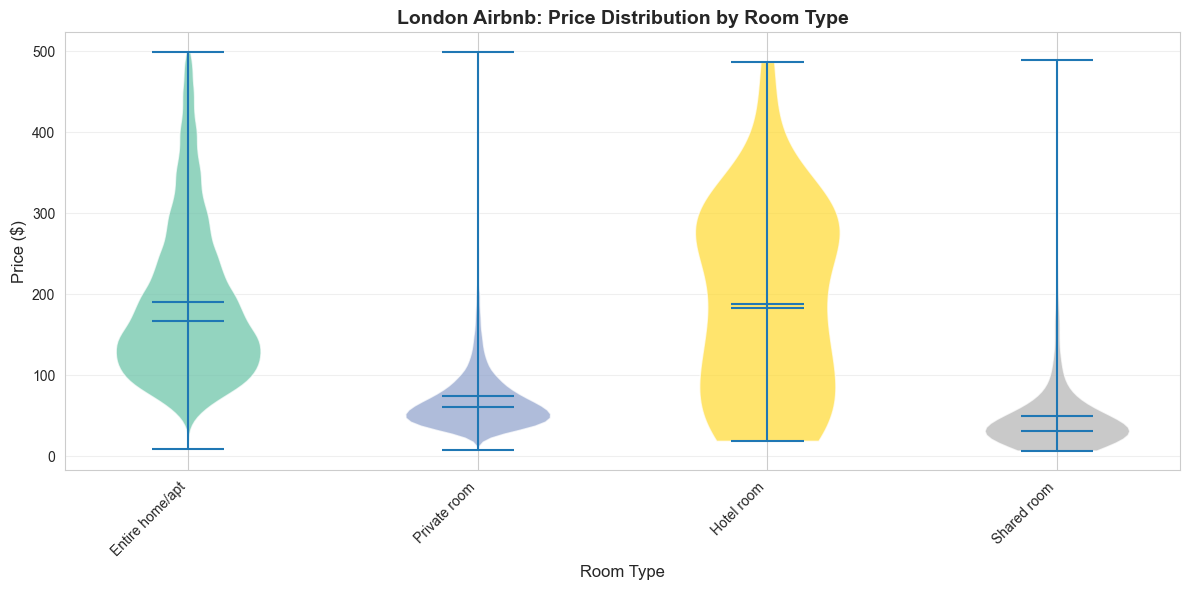

Saved viz1_price_distribution_violin.png


In [14]:
# Get data using PySpark
price_data = enriched.select("room_type", "price").filter(col("price") < 500).collect()

# Organize data by room type
room_types = {}
for row in price_data:
    rt = row['room_type']
    if rt not in room_types:
        room_types[rt] = []
    room_types[rt].append(row['price'])

# Create violin plot
fig, ax = plt.subplots(figsize=(12, 6))
positions = range(1, len(room_types) + 1)
parts = ax.violinplot(room_types.values(), positions=positions, showmeans=True, showmedians=True)

# Color the violins
colors = plt.cm.Set2(np.linspace(0, 1, len(room_types)))
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax.set_xticks(positions)
ax.set_xticklabels(room_types.keys(), rotation=45, ha='right')
ax.set_xlabel('Room Type', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('London Airbnb: Price Distribution by Room Type', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('output/viz1_price_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved viz1_price_distribution_violin.png")

## Visualization 2: Price vs Reviews Scatter Plot

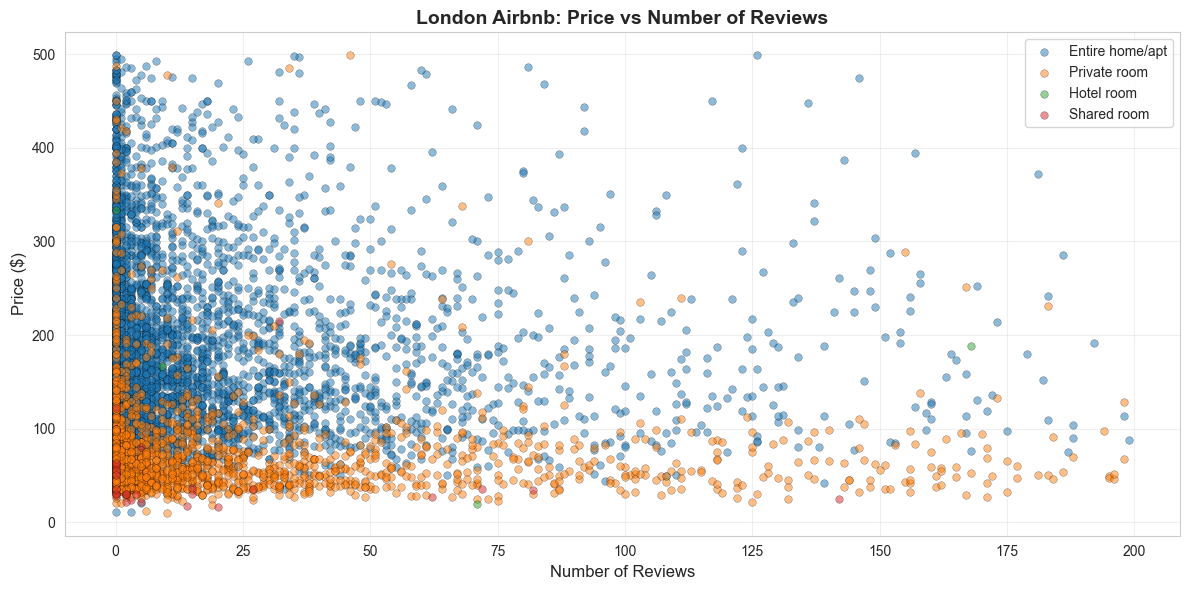

Saved viz2_price_vs_reviews.png


In [15]:
# Get sample data
scatter_data = enriched.select(
    "price", "number_of_reviews", "room_type"
).filter(
    (col("price") < 500) & (col("number_of_reviews") < 200)
).sample(0.1).collect()

# Organize by room type
room_type_data = {}
for row in scatter_data:
    rt = row['room_type']
    if rt not in room_type_data:
        room_type_data[rt] = {'reviews': [], 'prices': []}
    room_type_data[rt]['reviews'].append(row['number_of_reviews'])
    room_type_data[rt]['prices'].append(row['price'])

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, (rt, data) in enumerate(room_type_data.items()):
    ax.scatter(data['reviews'], data['prices'], 
              alpha=0.5, s=30, c=colors[i % len(colors)], label=rt, edgecolors='black', linewidth=0.3)

ax.set_xlabel('Number of Reviews', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('London Airbnb: Price vs Number of Reviews', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/viz2_price_vs_reviews.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved viz2_price_vs_reviews.png")

## Visualization 3: Availability Analysis Dashboard

C:\Users\selwy\AppData\Local\Temp\ipykernel_22600\3578274624.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(room_avail.values(), labels=room_avail.keys())


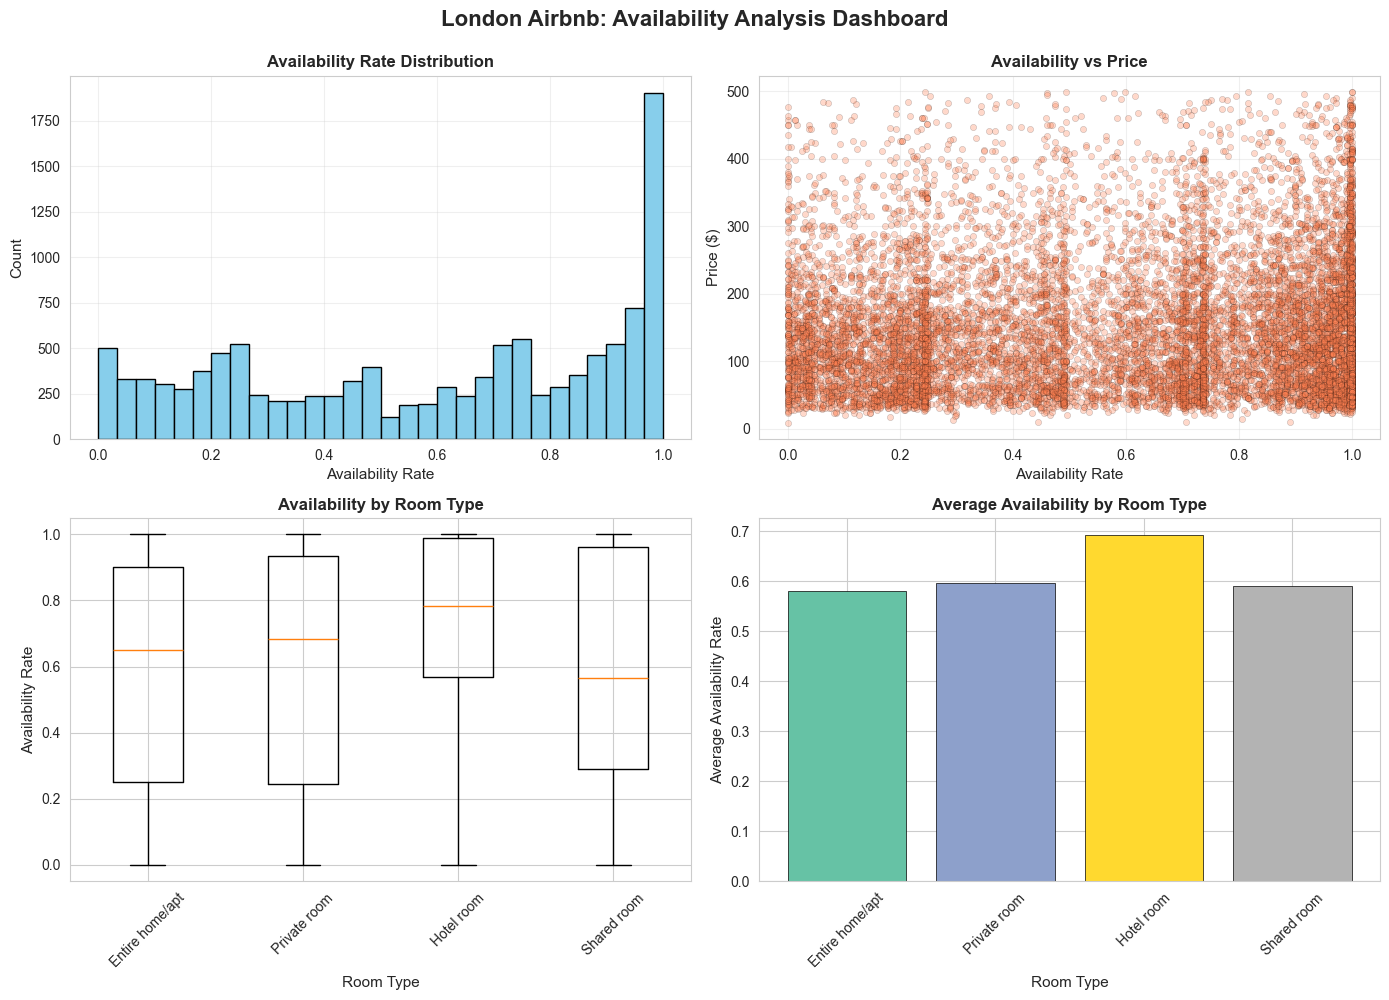

Saved viz3_availability_dashboard.png


In [16]:
# Get availability data
avail_data = enriched.select(
    "availability_rate", "price", "room_type"
).filter(
    col("availability_rate").isNotNull() & (col("price") < 500)
).sample(0.2).collect()

availability_rates = [row['availability_rate'] for row in avail_data]
prices = [row['price'] for row in avail_data]

room_avail = {}
for row in avail_data:
    rt = row['room_type']
    if rt not in room_avail:
        room_avail[rt] = []
    room_avail[rt].append(row['availability_rate'])

# Create 2x2 subplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.hist(availability_rates, bins=30, color='skyblue', edgecolor='black')
ax1.set_xlabel('Availability Rate', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Availability Rate Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.scatter(availability_rates, prices, alpha=0.3, s=20, color='coral', edgecolors='black', linewidth=0.3)
ax2.set_xlabel('Availability Rate', fontsize=11)
ax2.set_ylabel('Price ($)', fontsize=11)
ax2.set_title('Availability vs Price', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3.boxplot(room_avail.values(), labels=room_avail.keys())
ax3.set_xlabel('Room Type', fontsize=11)
ax3.set_ylabel('Availability Rate', fontsize=11)
ax3.set_title('Availability by Room Type', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

avg_avail = {rt: np.mean(rates) for rt, rates in room_avail.items()}
colors_bar = plt.cm.Set2(np.linspace(0, 1, len(avg_avail)))
ax4.bar(avg_avail.keys(), avg_avail.values(), color=colors_bar, edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Room Type', fontsize=11)
ax4.set_ylabel('Average Availability Rate', fontsize=11)
ax4.set_title('Average Availability by Room Type', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

plt.suptitle('London Airbnb: Availability Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('output/viz3_availability_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved viz3_availability_dashboard.png")

## Summary

In [18]:
print("\n" + "="*60)
print("LONDON AIRBNB ANALYSIS SUMMARY")
print("="*60)

total_listings = enriched.count()
avg_price = enriched.select(avg("price")).collect()[0][0]
avg_reviews = enriched.select(avg("number_of_reviews")).collect()[0][0]

print(f"\nTotal Listings: {total_listings:,}")
print(f"Average Price: £{avg_price:.2f}")
print(f"Average Reviews: {avg_reviews:.1f}")

print("\nRoom Type Distribution:")
enriched.groupBy("room_type").count().orderBy("count", ascending=False).show()

print("\n" + "="*60)
print("All visualizations saved to output/ folder")
print("="*60)
print("\nGenerated Files:")
print("  1. viz1_price_distribution_violin.png")
print("  2. viz2_price_vs_reviews.png")
print("  3. viz3_availability_dashboard.png")
print("\n High-resolution PNG files ready for reports!")
print("="*60)


LONDON AIRBNB ANALYSIS SUMMARY

Total Listings: 61,954
Average Price: £204.77
Average Reviews: 26.9

Room Type Distribution:
+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt|42316|
|   Private room|19375|
|    Shared room|  191|
|     Hotel room|   72|
+---------------+-----+


All visualizations saved to output/ folder

Generated Files:
  1. viz1_price_distribution_violin.png
  2. viz2_price_vs_reviews.png
  3. viz3_availability_dashboard.png

 High-resolution PNG files ready for reports!
